# Yield Rate Gender Gap, Part 4: Iterative imputation of missing values

*This is Part 4 of an investigation into the yield rate disparity in college admissions between women and men. This is a personal project I started to help me tie together using python for web scraping, data cleaning, data visualization, hypothesis testing, statistical modeling, machine learning, and more. I appreciate feedback!*

Let's load our scraped, cleaned, and combined CollegeData.com and US News dataset and remind ourselves of what it contains:

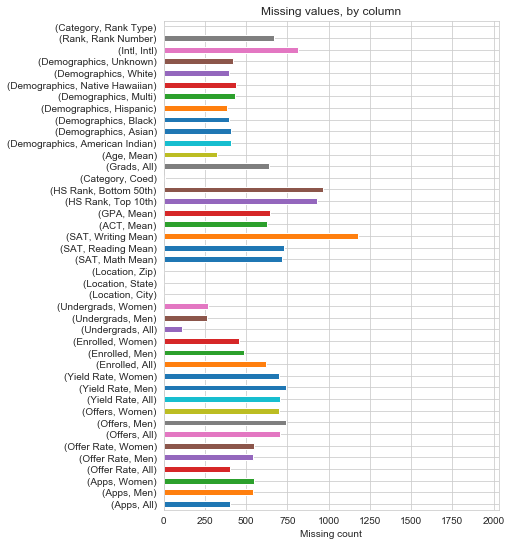

(2030, 42)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style of plots.
sns.set_style("whitegrid")

# Load CSV and set categorical variables.
df = pd.read_csv('data/college.csv', index_col=0, header=[0,1])

# Create new rank type, "Top 50 Universities".
cat = ('Category','Rank Type')
top_50 = (df[cat] == 'National Universities') & (df['Rank','Rank Number']<=50)
df.loc[top_50, cat] = 'Top 50 Universities'
cats = ['Top 50 Universities','National Universities',
        'National Liberal Arts Colleges','Regional Universities',
        'Regional Colleges','Unranked']
df[cat] = df[cat].astype('category')
df[cat].cat.reorder_categories(cats, inplace=True)

# Plot the amount of missingness per column.
f, ax = plt.subplots(1, 1, figsize=(6,9))
df.isna().sum().plot(kind='barh', ax=ax)
plt.title('Missing values, by column')
plt.xlabel('Missing count')
plt.xlim(0, df.shape[0])
plt.show()

# Show the shape.
df.shape

We have 42 different columns of values for 2030 schools, but there are a good amount of missing values in those columns. Before we deal with missing values, let's first check to make sure all of the existing values make sense.

---

## Finding and removing bad values

### Values that exceed limits

There could be nonsensical values in the dataframe from improper scraping back in Part 1 or even errors from the websites themselves that were never caught. We'll set lower and upper value limits for each column and check how many, if any, values exceed those limits for each column.

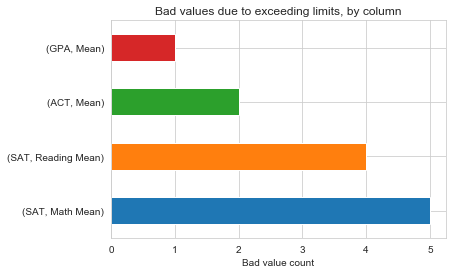

SAT                 ACT      GPA
                                      Math Mean Reading Mean   Mean     Mean
Name                                                                        
Dickinson State University                510.0        420.0   20.0  3120.00
Guilford College                          513.0         22.0  488.0     3.18
Kuyper College                            410.0          NaN  447.0     3.30
Lake Forest College                       520.0         52.0   26.0     3.62
Louisiana State University Alexandria      17.0        429.0   20.0     3.16
Marian University (WI)                     16.0         17.0   20.0     3.00
Oakland University                         19.0          NaN   23.0     3.40
Ohio Valley University                     44.0        410.0   18.0     3.17
Texas Woman's University                  410.0        940.0   17.0     3.10
University of Pennsylvania                140.0        723.0   33.0     3.91

In [56]:
# Define column value limits.
limits = {
    'ACT':(1, 36),
    'Age':(18, 65),
    'Apps':(0, 500000),
    'Demographics':(0,1),
    'Enrolled':(0, 500000),
    'GPA':(1,5),
    'Grads':(0, 500000),
    'HS Rank':(0,1),
    'Intl':(0,1),
    'Offer Rate':(0,1),
    'Offers':(0, 500000),
    'SAT':(200, 800),
    'Undergrads':(0,500000),
    'Yield Rate':(0,1)
}

badvals = pd.DataFrame(False, index=df.index, columns=df.columns)
    
# Check if col vals exceed limits.
for col in limits.keys():
    low, high = limits[col]
    badvals[col] = (df[col] < low) | (df[col] > high)

# Plot bad values count, by column.
badvals.loc[badvals.any(axis=1), badvals.any(axis=0)].sum().plot(kind='barh')
plt.title('Bad values due to exceeding limits, by column')
plt.xlabel('Bad value count')
plt.show()

# Show bad values.
df.loc[badvals.any(axis=1), badvals.any(axis=0)]

It's looks like some ACT and SAT scores might have been swapped, an a decimal place may be off for one of the GPAs. Instead of guessing the correct values, we'll just remove the bad values by setting them to NaN.

In [57]:
df = df.mask(badvals)

### Improper admissions values

Our dataframe has 'All', 'Men', and 'Women' values for 'Apps', 'Offers', 'Enrolled', and 'Undergrads'. If the number of Offers exceeds the number of Apps, or the number of Enrolled exeeds the Offers, or the number of Enrolled exceeds the total Undergrads, then we have bad values somewhere.

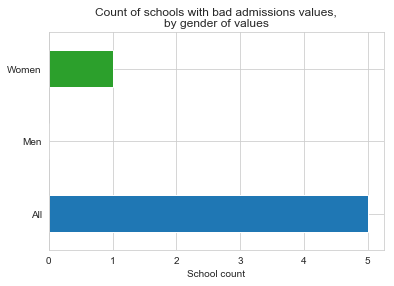

In [59]:
badvals = ((df['Apps'] < df['Offers'])
           | (df['Offers'] < df['Enrolled'])
           | (df['Enrolled'] > df['Undergrads']))

# Plot count of schools with bad admissions values.
badvals.sum().plot(kind='barh')
plt.title('Count of schools with bad admissions values,\nby gender of values')
plt.xlabel('School count')
plt.show()

Let's see what's wrong with the one school with bad 'Women' admissions values:

In [62]:
# Look at the values at schools with bad Women admissions values.
cols = ['Apps','Offers','Enrolled','Undergrads']
df.loc[badvals['Women'], cols].dropna(axis=1)

Apps                 Undergrads              
                          All     Men   Women        All    Men  Women
Name                                                                  
College of the Ozarks  2896.0  1090.0  1806.0     1512.0  684.0  828.0

It looks like this school is missing 'All' and 'Men' values for 'Offers' and 'Enrolled'. This itself is *not* a problem, but the fact that the number of Enrolled Women exceeds Offers Women *is* a problem. I'm not sure which value is bad, so we'll remove both of them.

Now we'll look at the erroneous 'All' values:

In [64]:
# Remove the Women values for Enrolled and Offers.
df.loc[badvals['Women'], [('Enrolled','Women'),('Offers','Women')]] = np.nan

# Look at the values at schools with bad All admissions values.
df.loc[badvals['All'], cols].dropna(axis=1)

Apps                  \
                                                        All     Men   Women   
Name                                                                          
Blessing-Reiman College of Nursing                    546.0    30.0   516.0   
Medgar Evers College (City University of New York)  10105.0  4005.0  6100.0   
Northwestern Polytechnic University                   249.0   150.0    99.0   
Paine College                                        3964.0  1396.0  2568.0   
University of the Ozarks                              744.0   311.0   433.0   

                                                   Enrolled Undergrads  
                                                        All        All  
Name                                                                    
Blessing-Reiman College of Nursing                    362.0      233.0  
Medgar Evers College (City University of New York)   9864.0     6819.0  
Northwestern Polytechnic University                   248.0      164.0  
Paine College                                         977.0      502.0  
University of the Ozarks                              720.0      651.0

These schools also only have gender breakdown for Apps, and they all have no information at all regarding Offers. Again, this is not an error, but all of these schools do have a common error - the Enrolled is somehow higher than the Undergrads. It's difficult to determine which of these two columns is the 'bad' one, so we'll just remove both values for these schools:

In [65]:
df.loc[badvals_df['All'], [('Enrolled','All'),('Undergrads','All')]] = np.nan

---

### Improper gender sums

Now let's check for any schools where the Apps, Offers, Enrolled, and Undergrads columns, when Men/Women gender breakdown is available, erroneously do not add up to the total All amount:

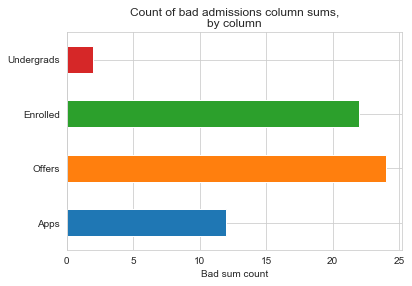

In [69]:
def check_bad_admissions_sums(data):
    admissions_cols = ['Apps','Offers','Enrolled','Undergrads']
    badvals = pd.DataFrame(False, index=data.index, columns=admissions_cols)
    
    for col in admissions_cols:
        has_all_val = data[col]['All'].notna()
        has_gender_val = data[col][['Men','Women']].notna().any(axis=1)
        gender_val_sum = data[col][['Men','Women']].sum(axis=1).round()
        all_val = data[col,'All'].round()
        
        badvals[col] = (has_all_val 
                        & has_gender_val 
                        & (gender_val_sum != all_val))
    return badvals
        

badvals = check_bad_admissions_sums(df)

# Plot count of schools with bad sums of gender values.
badvals.sum().plot(kind='barh')
plt.title('Count of bad admissions column sums,\nby column')
plt.xlabel('Bad sum count')
plt.show()

We'll 'trust' the All values for these schools and remove both of their Men/Women values:

In [70]:
for col in badvals.columns:
    df.loc[badvals[col], [(col,'Men'),(col,'Women')]] = np.nan

---

### Improper demographics sums

Now let's check for any schools with domestic undergraduate demographics data summing to something far from 1.00:

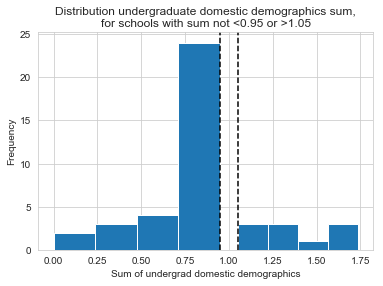

In [72]:
# Find demographic sums not near 1.00.
has_some_data = df['Demographics'].notna().any(axis=1)
demo_sum = df['Demographics'].sum(axis=1)

bad_demos = has_some_data & ((demo_sum < 0.95) | (demo_sum > 1.05))

# Plot histogram of anomalous demographic sums.
hist_bins = np.concatenate((
    np.linspace(demo_sum.min(), 0.95, 5), 
    np.linspace(1.05, demo_sum.max(), 5)))

demo_sum.loc[bad_demos].plot.hist(bins=hist_bins)

plt.axvline(0.95, color='k', linestyle='dashed')
plt.axvline(1.05, color='k', linestyle='dashed')

plt.title('Distribution undergraduate domestic demographics sum,\n'
          'for schools with sum not <0.95 or >1.05')
plt.xlabel('Sum of undergrad domestic demographics')
plt.show()

I'm not going to be able to figure out what demographics values are correct or erroneous, so I'll just drop all demographics values for these schools:

In [73]:
df.loc[bad_demos, 'Demographics'] = np.nan

---

## Dropping outlier schools

Now that we've dealt with erroneous values, we're still not ready to impute values to replace our missing data. During our imputation procedure, we'll rely on the values of other schools with the relevant data to provide an estimate for our missing data. This can become inaccurate if the other schools are so different from each other that they can be thought of as a seperate sub population.

### Unusual gender ratios

Since our end goal is to analyze the gender gap in the yield rate, we're not going to be terribly interested in schools that are not coeducational. Fortunately, single gender schools are already identified in our dataset. Unfortunately, there are many schools that, while nominally coed, are over 85% one gender. These schools can be imagined as members of a subpopulation different from those we are interested in analyzing. 

We can identify any school with more than 85% of the student body as one gender and classify them as "Mostly Men" or "Mostly Women", in addition to our existing "Men Only" and "Women Only" categories:

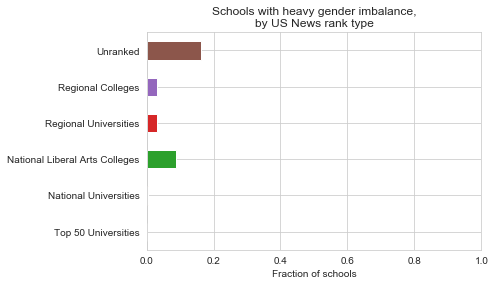

In [12]:
coed_cat = ('Category','Coed')
rank_cat = ('Category','Rank Type')

# Set limits for unusual gender ratios.
LOW = 0.15
HIGH = 0.85

# Mark nominally 'coed' schools with unusual ratio as 'mostly' men or women.
pct_women = df['Undergrads','Women'] / df['Undergrads','All']
mostly_women = ((pct_women > HIGH) & (df[coed_cat] != 'Women Only'))
mostly_men = ((pct_women < LOW) & (df[coed_cat] != 'Men Only'))  
df.loc[mostly_women, coed_cat] = 'Women Mostly'
df.loc[mostly_men, coed_cat] = 'Men Mostly'

# Make coed status a categorical variable.
df[coed_cat] = df[coed_cat].astype('category')

# Get a count of non-coed schools by rank type.
non_coed_schools = df[coed_cat] != 'Yes'
non_coed_count = df.loc[non_coed_schools].groupby(rank_cat).size()

# Get a count of all schools by rank type.
all_count = df.groupby(rank_cat).size()

# Plot non-coed fraction of schools by US News rank type.
(non_coed_count / all_count).plot(kind='barh')
plt.xlim(0,1)
plt.title('Schools with heavy gender imbalance,\nby US News rank type')
plt.xlabel('Fraction of schools')
plt.ylabel('')
plt.show()

It seems none of our Top 50 Universities or National Universities contain any of these schools, though around 15% of the unranked schools are pretty much single gendered, officially or not.

---

### Unusual freshmen fraction of undergraduates

The Freshmen Ratio - the ratio of 'Enrolled' to 'Undergrads' - can be thought of as the incoming freshmen percentage of the total undergraduate population. Ideally, this would be 0.25 if every enrolled student remained enrolled for four years and then graduated with no increase or decrease in incoming class size from year to year. In practice, this can vary due to a rapid increase or decrease in enrollment as well as large student dropout or incoming transfers.

We're going to arbitrarily mark schools as 'unusual' that have a Freshmen Ratio lower than 0.10 or higher than 0.50. If less than 0.1 of undergraduates are freshmen, enrollment could be plummeting and the school is dying or students are transferring in at a tremendous rate. If the ratio is above 0.5, then students enrollment might be skyrocketing or student are transferring out en masse. Either way, these schools don't seem likely to have the normal values we would want to use for our imputation procedure.

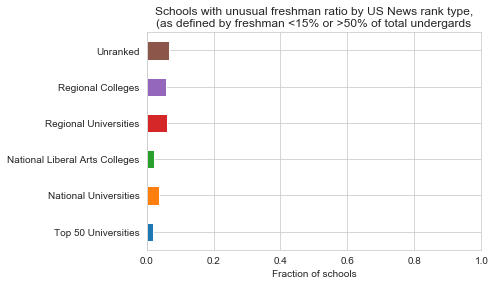

In [75]:
# Compute new freshmen ratio column.
for gender in ['All','Men','Women']:
    df['Freshmen Ratio',gender] = \
                            df['Enrolled',gender] / df['Undergrads',gender]

# Create new category.
df['Category','Unusual Freshmen Ratio'] = False

# Set limits for unusual freshmen ratios.
LOW = 0.15
HIGH = 0.50
df['Category','Unusual Freshmen Ratio'] = \
      (df['Freshmen Ratio','All'] < LOW) | (df['Freshmen Ratio','All'] > HIGH)
    
# Get a count of schools with unusual freshmen ratio by US News rank type.
unusual_ratio = df['Category','Unusual Freshmen Ratio'] == True
unusual_ratio_count = df.loc[unusual_ratio].groupby(rank_cat).size()

# Plot unusual freshmen ratio fraction of schools by US News rank type.
(unusual_ratio_count / all_count).plot(kind='barh')
plt.title('Schools with unusual freshman ratio by US News rank type,\n'
          '(as defined by freshman <15% or >50% of total undergards')
plt.xlim(0,1)
plt.xlabel('Fraction of schools')
plt.ylabel('')
plt.show()

Around 5% of schools were identified as having 'unusual' Freshmen Ratios.

--- 

### Missing all admissions data

Finally, let's see how many schools are completely missing all of the admissions data - the columns Apps, Offers, Enrolled, and Undergrads:

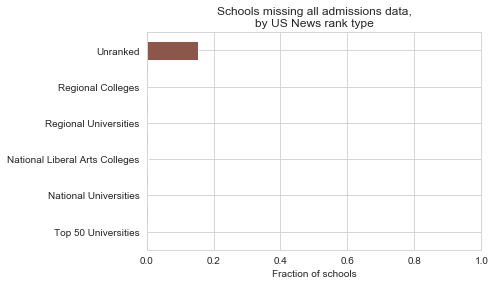

In [14]:
# Assess missingness of admissions columns.
cols = ['Apps','Offers','Enrolled','Undergrads']
missing_all = df[cols].isna().all(axis=1)
missing_some = df[cols].isna().any(axis=1) & ~missing_all
complete_case = df[cols].notna().all(axis=1)

# Add new category for missing status.
col = ('Category','Admissions Missing')
df.loc[missing_all, col] = 'Missing All'
df.loc[missing_some, col] = 'Missing Some'
df.loc[complete_case, col] = 'Complete Case'
df[col] = df[col].astype('category')

# Get a count of schools missing all admissions data by US News rank type.
missing_all_count = df.loc[missing_all].groupby(rank_cat).size()

# Plot unusual freshmen ratio fraction of schools by US News rank type.
(missing_all_count / all_count).plot(kind='barh')
plt.title('Schools missing all admissions data,\nby US News rank type')
plt.xlim(0,1)
plt.xlabel('Fraction of schools')
plt.ylabel('')
plt.show()

About 15% of unranked schools have no admissions data whatsoever. There's very little accurate imputation we could make at these schools.

---

### Outlier summary

When imputing missing values, we will want to only consider schools that are coed, schools that don't have an unusual Freshmen Ratio, and schools that aren't missing all of their admissions data. Counting up these schools by US News rank type:

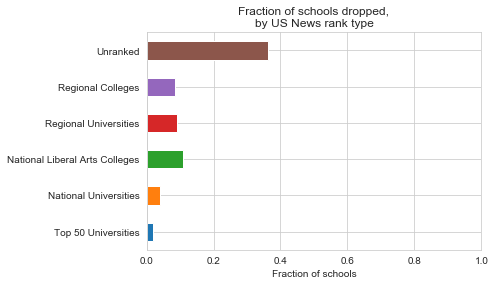

Original schools: 2030
Schools to drop: 354
Total fraction to be dropped: 0.17


In [76]:
# Keep only schools that are coed, not heavily graduate,
#   not unusual freshmen ratio, and not missing all admissions values.
to_drop = non_coed_schools | unusual_ratio | missing_all

# Get count of schools in reduced dataframe by US News rank type.
drop_count = df.loc[to_drop].groupby(rank_cat).size()

# Plot fraction of schools dropped by US News rank type.
(drop_count/all_count).plot(kind='barh')
plt.title('Fraction of schools dropped,\nby US News rank type')
plt.xlabel('Fraction of schools')
plt.ylabel('')
plt.xlim(0,1)
plt.show()

# Show shape of reduced dataframe
print("Original schools: {}".format(len(df)))
print("Schools to drop: {}".format(len(df.loc[to_drop])))
print("Total fraction to be dropped: {:.2f}".format(len(df.loc[to_drop])/len(df)))

We're going to cut 17% of schools from the imputation procedure.

---

## Imputation

### Reducing dependent columns

Before we get started, many of our variables depend on other variables. For example, the three columns `'Undergrads','All'`, `'Undergrads','Men'`, and `'Undergrads','Women'` - are not independent. They can be reduced to two columns, a single `'Undergrads'` column holding the All values, and a `'Undergrads % Women'` column. By multiplying these two independent columns together, you can recover the original `'Undergrads','Women'` column, and by subtracting the Women values from the All value, the `'Undergrads','Men'` can be recovered.

With the end goal of removing all dependent columns in mind, as well as dropping the schools from the prior section's analysis, we create a new reduced dataframe:

In [95]:
# Create new blank dataframe with the same index as the original.
reduced_df = pd.DataFrame(index=df.index)

# Copy the total undergrad count as it is.
reduced_df['Undergrads'] = df['Undergrads','All']

# Compute rates connecting Undergrads, Enrolled, Offers, and Apps.
reduced_df['Freshmen Ratio'] = df['Enrolled','All'] / df['Undergrads','All']
reduced_df['Yield Rate'] = df['Enrolled','All'] / df['Offers','All']
reduced_df['Offer Rate'] = df['Offers','All'] / df['Apps','All']

# Compute rates connecting All, Men, and Women values of the prior columns.
reduced_df['Undergrads % Women'] = \
                             df['Undergrads','Women'] / df['Undergrads','All']
reduced_df['Enrolled % Women'] = df['Enrolled','Women'] / df['Enrolled','All']
reduced_df['Offers % Women'] = df['Offers','Women'] / df['Offers','All']
reduced_df['Apps % Women'] = df['Apps','Women'] / df['Apps','All']

# Copy the Demographics values as they are.
for col in df['Demographics']:
    reduced_df[col] = df['Demographics',col]

# Copy the SAT values as they are.
for col in df['SAT']:
    reduced_df['SAT '+col] = df['SAT',col]

# Copy the HS Rank values as they are.
for col in df['HS Rank']:
    reduced_df['HS Rank '+col] = df['HS Rank',col]
    
# Copy the ACT, GPA, Intl, Age, and Rank values as they are.
reduced_df['ACT'] = df['ACT','Mean']
reduced_df['GPA'] = df['GPA','Mean']
reduced_df['Intl'] = df['Intl','Intl']
reduced_df['Age'] = df['Age','Mean']
reduced_df['Rank'] = df['Rank','Rank Number']

# Copy the Grad % as it is.
reduced_df['Grads %'] = df['Grads','All'] / (df['Undergrads','All']
                                             + df['Grads','All'])
reduced_df = reduced_df.loc[~to_drop]

reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1676 entries, Abilene Christian University to Youngstown State University
Data columns (total 27 columns):
Undergrads             1668 non-null float64
Freshmen Ratio         1222 non-null float64
Yield Rate             1196 non-null float64
Offer Rate             1195 non-null float64
Undergrads % Women     1584 non-null float64
Enrolled % Women       1177 non-null float64
Offers % Women         1177 non-null float64
Apps % Women           1316 non-null float64
American Indian        1424 non-null float64
Asian                  1427 non-null float64
Black                  1430 non-null float64
Hispanic               1439 non-null float64
Multi                  1406 non-null float64
Native Hawaiian        1406 non-null float64
White                  1432 non-null float64
Unknown                1417 non-null float64
SAT Math Mean          1201 non-null float64
SAT Reading Mean       1191 non-null float64
SAT Writing Mean       777 non-null fl

We've reduce our original 2030 schools with 42 columns to 1676 schools with 27 independent numeric columns.

---

### Simple mean imputation

Now there are still missing values in this reduced dataframe that need to be imputed. Let's look at the relationship between Yield Rate and GPA with a scatter plot. We'll first plot the original data, and next to it we'll plot the data with the column means imputed to replace the missing values:

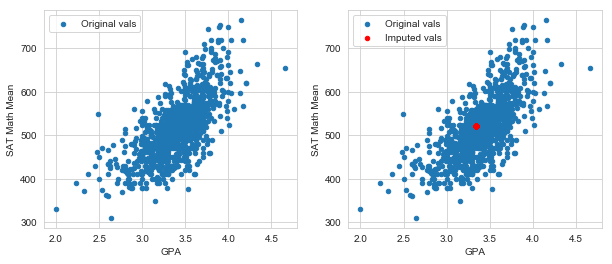

,GPA,SAT Math Mean,GPA with imputed,SAT Math Mean with imputed
count,1258.00,1201.00,1676.00,1676.00
mean,3.35,521.19,3.35,521.19
std,0.32,78.06,0.28,66.07
min,2.00,248.00,2.00,248.00
25%,3.18,470.00,3.24,487.00
50%,3.37,511.00,3.35,521.19
75%,3.56,562.00,3.50,542.00
max,4.66,772.00,4.66,772.00


In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Plot left figure - original vals only.
reduced_df.plot.scatter('GPA', 'SAT Math Mean', label='Original vals', ax=ax1)

# Plot right figure - original vals with mean imputed vals.
reduced_df.plot.scatter('GPA', 'SAT Math Mean', label='Original vals', ax=ax2)
reduced_df.fillna(reduced_df.mean()).where(reduced_df.isna())\
                            .plot.scatter('GPA', 'SAT Math Mean', ax=ax2, 
                                          color='red', label='Imputed vals')
plt.show()

# Descriptive statistics without and with mean imputation.
reduced_df[['GPA','SAT Math Mean']].describe().join(\
    reduced_df.fillna(reduced_df.mean())[['GPA','SAT Math Mean']]\
                                .describe(), rsuffix=' with imputed').round(2)

There are hundreds of missing values for each of these two variables. Notice that since the mean is used to fill the missing value, the hundreds of missing values all have a GPA value of 3.35 and SAT Math Mean of 521.16, and these hundreds of points all map on to the same location on the right plot - the red dot in the middle. 

While simple, this imputation method artificially lowers the standard deviation and tightens the distribution of column values, which could wash out or overemphasize possible correlations these columsn could have with with other columns. We can do better.

---

### Iterative imputation

An improved method to deal with missing values called **iterative imputation** involves holding one target column constant at a time while imputing the column means to fill the missing values in the other predictor columns. These imputed predictor columns are then used to run a multiple regression to impute values for the missing data in the target column. 

We then repeat the process using the second column as the target, removing the previously imputed values, and using the remaining columns (with their imputed values) as predictors in another multiple regression.

We run this procedure for every column in the dataframe - this is one cycle. We will run 10 cycles, then check how it turned out for the GPA and SAT Math Mean scatterplot:

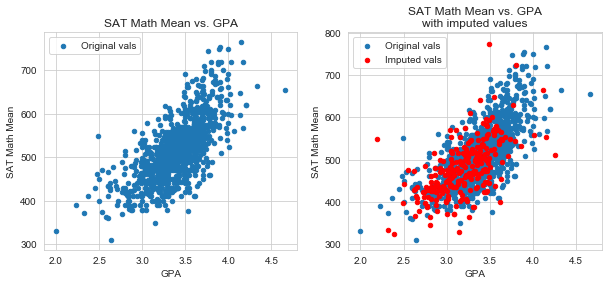

,GPA,SAT Math Mean,GPA with imputed,SAT Math Mean with imputed
count,1258.00,1201.00,1676.00,1676.00
mean,3.35,521.19,3.34,509.31
std,0.32,78.06,0.34,76.75
min,2.00,248.00,2.00,248.00
25%,3.18,470.00,3.14,459.94
50%,3.37,511.00,3.35,503.00
75%,3.56,562.00,3.56,551.00
max,4.66,772.00,4.66,772.00


In [97]:
from sklearn import linear_model

# Mark the originally missing values.
missing_df = reduced_df.isna()

# Fill missing values with column means.
reduced_df = reduced_df.fillna(reduced_df.mean())

# Set new col limits to our current col min and max
reduced_limits = {}
for col in reduced_df.columns:
    reduced_limits[col] = (reduced_df[col].min(), reduced_df[col].max())

# This is the number of imputation cycles through the columns.
CYCLES = 20
for i in range(0, CYCLES):
    for col in reduced_df.columns:

        # The target column's original missingness is restored.
        Y = reduced_df[col].mask(missing_df[col])

        # The predictor columns are all cols except the target.
        X = reduced_df.drop(columns=col)

        # Fit lin. reg. model using non-missing Y vals and associated X vals.
        myRegressor = linear_model.LinearRegression()
        myRegressor.fit(X[Y.notna()], Y[Y.notna()])
        
        # Get errors between predicted Y and actual Y for non-missing Y vals.
        err = myRegressor.predict(X[Y.notna()]) - Y[Y.notna()]

        # Randomly draw errors for all the Y values with missing vals.
        random_err = np.random.choice(err, Y.isna().sum())

        # Impute missing Y vals with predicted Y plus randomly drawn error.
        if Y.isna().sum() > 0:
            Y.loc[Y.isna()] = myRegressor.predict(X[Y.isna()]) + random_err
            
            # Clip imputed Y value if it exceeds pre-defined col limits.
            if col in reduced_limits.keys():
                low, high = reduced_limits[col]
                Y.clip(low, high, inplace=True)
        
        # Overwrite target col in df with new col with missing vals imputed.
        reduced_df.loc[:,col] = Y
        

# Check imputation:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Plot left figure - original vals only.
col1 = 'GPA'
col2 = 'SAT Math Mean'
label='Original vals'
reduced_df.mask(missing_df).plot.scatter(col1, col2, label='Original vals', ax=ax1)
ax1.set_title('SAT Math Mean vs. GPA')

# Plot right figure - original vals with mean imputed vals.
reduced_df.mask(missing_df).plot.scatter('GPA', 'SAT Math Mean', 
                                         label='Original vals', ax=ax2)
reduced_df.where(missing_df).plot.scatter('GPA', 'SAT Math Mean', color='red',
                                          label='Imputed vals', ax=ax2)
ax2.set_title('SAT Math Mean vs. GPA\nwith imputed values')
plt.show()

# Descriptive statistics without and with mean imputation.
reduced_df.mask(missing_df)[['GPA','SAT Math Mean']].describe().join(\
    reduced_df[['GPA','SAT Math Mean']].describe(), \
    rsuffix=' with imputed').round(2)

The iterative imputed values have a more natural distribution than those from the simple mean imputation, but their distributions are not identical to the distributions of the original values. For example, while the mean GPA remained roughly unchanged after imputation, the SAT Math Mean decreased (perhaps significantly) with imputation. This means imputed SAT Math values were on average lower than the original SAT Math values.

The imputation procedure has suggested that schools with missing SAT scores are more likely have reported lower SAT scores on average had they reported them. What particular factors in the iterative imputation led to these results are not immediately obvious without futher exploration of the data set, which we will another day in the next part.

---

### Expanding the imputed reduced dataframe

To facilitate easier analysis, we will expand our reduced data frame to include the same columns as our original dataframe:

In [81]:
# Un-reduce the imputed dataframe back to a new dataframe with original cols.
imputed_df = pd.DataFrame(columns=df.columns)

# Copy the total Undergrads as it is.
imputed_df['Undergrads','All'] = reduced_df['Undergrads']

# Reconstruct the total Enrolled/Offers/Apps from the rates.
imputed_df['Enrolled','All'] = \
            imputed_df['Undergrads','All'] * reduced_df['Freshmen Ratio']
imputed_df['Offers','All'] = \
            imputed_df['Enrolled','All'] / reduced_df['Yield Rate']
imputed_df['Apps','All'] = \
            imputed_df['Offers','All'] / reduced_df['Offer Rate']

# Reconstruct the Women columns using the Women percentages.
imputed_df['Undergrads','Women'] = \
            imputed_df['Undergrads','All'] * reduced_df['Undergrads % Women']
imputed_df['Enrolled','Women'] = \
            imputed_df['Enrolled','All'] * reduced_df['Enrolled % Women']
imputed_df['Offers','Women'] = \
            imputed_df['Offers','All'] * reduced_df['Offers % Women']
imputed_df['Apps','Women'] = \
            imputed_df['Apps','All'] * reduced_df['Apps % Women']

# Subtract Women from All to get the Men columns.
for col in ['Undergrads','Enrolled','Offers','Apps']:
    imputed_df[col,'Men'] = imputed_df[col,'All'] - imputed_df[col,'Women']

# Compute the Offer Rates and Yield Rates, by gender.
imputed_df['Offer Rate'] = imputed_df['Offers'] / imputed_df['Apps']
imputed_df['Yield Rate'] = imputed_df['Enrolled'] / imputed_df['Offers']
imputed_df['Freshmen Ratio'] =\
                            imputed_df['Enrolled'] / imputed_df['Undergrads']

# Compute the total Grads.
imputed_df['Grads','All'] = \
            imputed_df['Undergrads','All'] * reduced_df['Grads %'] \
            / (1 - reduced_df['Grads %'])
imputed_df['Grads','Percent'] = reduced_df['Grads %']

# Copy the Demographics values as they are.
for col in imputed_df['Demographics']:
    imputed_df['Demographics',col] = reduced_df[col]

# Copy the SAT values as they are.
for col in imputed_df['SAT']:
    imputed_df['SAT',col] = reduced_df['SAT '+col]

# Copy the HS Rank values as they are.
for col in imputed_df['HS Rank']:
    imputed_df['HS Rank',col] = reduced_df['HS Rank '+col]
    
# Copy the ACT, GPA, Intl, Age, and Rank values as they are.
imputed_df['ACT','Mean'] = reduced_df['ACT']
imputed_df['GPA','Mean'] = reduced_df['GPA']
imputed_df['Intl','Intl'] = reduced_df['Intl']
imputed_df['Age','Mean'] = reduced_df['Age']
imputed_df['Rank','Rank Number'] = reduced_df['Rank']

# Remove unused columns from imputed dataframe.
imputed_df.columns = imputed_df.columns.remove_unused_levels()

# If imputed yield rate > 1 for a gender, set its offers = enrollments.
for gender in ['Men','Women']:
    bad_yld_rate = imputed_df['Yield Rate',gender] > 1
    imputed_df.loc[bad_yld_rate, ('Offers',gender)] = \
                            imputed_df.loc[bad_yld_rate, ('Enrolled',gender)]
    imputed_df['Offers','All'] = \
                    imputed_df['Offers','Men'] + imputed_df['Offers','Women']
    imputed_df['Yield Rate'] = imputed_df['Enrolled'] / imputed_df['Offers']
    imputed_df['Offer Rate'] = imputed_df['Offers'] / imputed_df['Apps']
    
# If imputed offer rate > 1 for a gender, set its apps = offers.
for gender in ['Men','Women']:
    bad_off_rate = imputed_df['Offer Rate',gender] > 1
    imputed_df.loc[bad_off_rate, ('Apps',gender)] \
                            = imputed_df.loc[bad_off_rate, ('Offers',gender)]
    imputed_df['Apps','All'] = \
                        imputed_df['Apps','Men'] + imputed_df['Apps','Women']
    imputed_df['Offer Rate'] = imputed_df['Offers'] / imputed_df['Apps']
    

# Fill remaining values in the imputed dataframe with the original values.
imputed_df = imputed_df.fillna(df)


---

## Yield rate gap

### Distribution of yield rates by case

Not counting the 105 schools that are missing all admissions values, we have four cases:
- The **original population** of 1925 schools, including 1238 with originally complete values.
- The **dropped subpopulation** of 249 schools, including 84 with originally complete values.
- The **kept subpopulation** of 1676 schools, with 1154 with originally complete values.
- The **imputed kept subpopulation** of 1676 schools, all with complete (imputed) admissions values.

We will look at the emperical cumulative distribution functions (ECDF) for the `'Yield Rate (men)'` and `'Yield Rate (men)'` for each of these four cases. We will also create a new column `'Yield Rate (diff)'` that shows the difference between these two and check its ECDFs for the four cases.

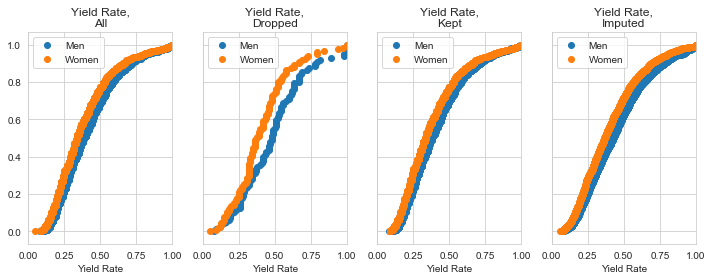

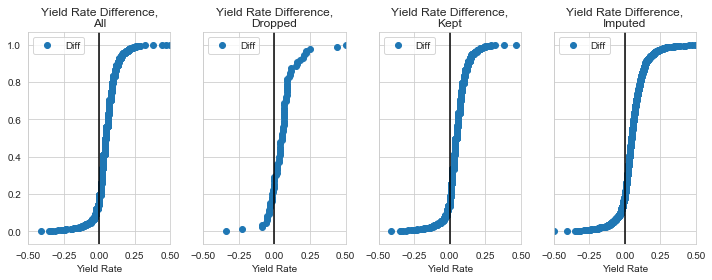

Yield Rate (diff)                           Yield Rate (men)          \
                    All Dropped     Kept  Imputed              All Dropped   
count           1264.00   87.00  1177.00  1676.00          1286.00   97.00   
mean               0.05    0.05     0.05     0.05             0.42    0.49   
std                0.08    0.11     0.08     0.09             0.20    0.23   
min               -0.41   -0.34    -0.41    -0.50             0.08    0.08   
25%                0.01    0.00     0.01     0.01             0.26    0.32   
50%                0.05    0.05     0.05     0.05             0.39    0.48   
75%                0.09    0.09     0.09     0.09             0.54    0.62   
max                0.64    0.50     0.64     0.64             1.00    1.00   

                        Yield Rate (women)                            
          Kept  Imputed                All Dropped     Kept  Imputed  
count  1189.00  1676.00            1328.00  120.00  1208.00  1676.00  
mean      0.42     0.45               0.38    0.41     0.38     0.40  
std       0.20     0.22               0.20    0.19     0.20     0.21  
min       0.08     0.07               0.05    0.05     0.09     0.06  
25%       0.26     0.27               0.23    0.29     0.23     0.24  
50%       0.38     0.43               0.34    0.38     0.34     0.37  
75%       0.54     0.59               0.49    0.51     0.49     0.53  
max       1.00     1.00               1.00    1.00     1.00     1.00

In [164]:
cases = ['All','Dropped','Kept','Imputed']

def get_rate_diffs(col):
    # Get the all, men, women, diff rate columns for each of the four cases.
    col1 = (col,'Men')
    m_cols = [df[col1], df.loc[to_drop,col1], 
              df.loc[~to_drop,col1], imputed_df[col1]]
    col2 = (col,'Women')
    w_cols = [df[col2], df.loc[to_drop,col2], 
              df.loc[~to_drop,col2], imputed_df[col2]]
    gap_col = (col,'Diff')
    df[gap_col] = df[col,'Men'] - df[col,'Women']
    imputed_df[gap_col] = imputed_df[col,'Men'] - imputed_df[col,'Women']
    d_cols = [df[gap_col], df.loc[to_drop,gap_col], 
              df.loc[~to_drop,gap_col], imputed_df[gap_col]]
    
    # Create all, men, women, diff rate dfs, each w/rates for each case.
    idx = pd.MultiIndex.from_product([[col+' (men)'],cases])
    men = pd.DataFrame(m_cols, index=idx).T
    idx = pd.MultiIndex.from_product([[col+' (women)'],cases])
    women = pd.DataFrame(w_cols, index=idx).T
    idx = pd.MultiIndex.from_product([[col+' (diff)'],cases])
    diff = pd.DataFrame(d_cols, index=idx).T

    # Create yield rate table 
    rates = diff.join([men, women])
    
    return rates


def plot_rate_ECDFs(rates, col):
    
    # Plot ECDFs of men and women yield rates, by case.
    f, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
    ax_dict = dict(zip(labels, axes))
    for label in labels:
        ax = ax_dict[label]
        ECDF(rates[col+' (men)'][label].rename('Men'), ax=ax)
        ECDF(rates[col+' (women)'][label].rename('Women'), ax=ax)
        ax.set_title(col+',\n{}'.format(label))
        ax.set_xlabel(col)
        ax.set_ylabel('')
        ax.set_xlim((0,1))
    plt.tight_layout()
    plt.show()
    
    
    # Plot ECDFs for Yield Rate (diff), by case.
    f, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
    ax_dict = dict(zip(labels, axes))
    for label in labels:
        ax = ax_dict[label]
        ECDF(rates[col+' (diff)'][label].rename('Diff'), ax=ax)
        ax.set_title(col+' Difference,\n{}'.format(label))
        ax.set_xlabel(col)
        ax.axvline(0, color='k')
        ax.set_ylabel('')
        ax.set_xlim((-0.5,0.5))
    plt.tight_layout()
    plt.show()
    
    
# Function to plot ECDF for a series on current axes named 'ax'.
def ECDF(series, ax):
    X = series.dropna().sort_values()
    Y = np.linspace(0, 1, series.dropna().shape[0])
    ax.scatter(X, Y, label=series.name)
    ax.set_title('ECDF of ' + series.name)
    ax.set_xlabel(series.name)
    ax.set_ylabel('ECDF')
    ax.legend()

# Get yield rate differences.
yld_rates = get_rate_diffs('Yield Rate')

# Plot ECDFs of yield rate differences.
plot_rate_ECDFs(yld_rates, 'Yield Rate')

# Show table of summary statistics for men and women yield rates.
yld_rates.describe().round(2)

It seems that there is a consistent 5% yield rate difference, no matter the case. This means that across all schools, the `'Yield Rate (men)'` is 5% higher than the `'Yield Rate (women)'`, meaning male applicants are overall more likely to accept offer letters from a university than female applicants. But is this 5% yield rate gap significant?

---

### Hypothesis testing the yield rate gender gap

Our null hypothesis $H_0$ is the claim that the population mean ${\mu}_w$ of the `'Yield Rate (women)'` $=X_{w}$ is not any different than the population mean $\mu_{m}$ of `'Yield Rate (men)'`$=X_{m}$, or in terms of their difference $d$:

$$H_0: {\mu}_{m} - {\mu}_{w} = {\mu}_{d} = 0$$
$$H_a: {\mu}_{m} - {\mu}_{w} = {\mu}_{d} \neq 0$$

Since each observation of the `'Yield Rate (diff)'`$=d_i=X_{m,i}-X_{w,i}$ requires a linked pair of values from `'Yield Rate (men)'` and `'Yield Rate (women)'`, we should perform a two-tailed matched pair t-test. However, since our number of schools $n \gg 30$ for each of our four subpopulations, we could approximate each t-test using a z-test. 

For the matched pair z-test to be valid, our $X_m$ and $X_w$ do not necessarily need to be normally distributed, but their differences $d_i = X_{m,i} - X_{w,i}$ should be approximately normal for all populations:

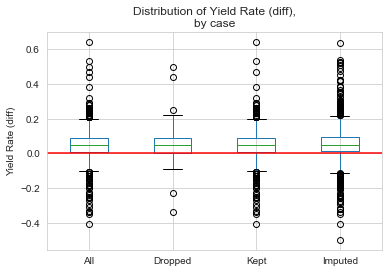

In [167]:
plt.title('Distribution of Yield Rate (diff),\nby case')
yld_rates['Yield Rate (diff)'].boxplot()
plt.ylabel('Yield Rate (diff)')
plt.axhline(0, color='r')
plt.show()

Since these differences look approximately normal, we can continue with our hypothesis testing.

In [168]:
from scipy.stats import ttest_rel

def test_diff(series1, series2, ALPHA=0.01):
    t, ttest_pval = ttest_rel(series1, series2, nan_policy='omit')
    reject_equal_means = ttest_pval < ALPHA
    return ttest_pval, reject_equal_means    

def diff_summary(rates, col):
    # Create new dataframe to hold summary of equal means hypothesis tests.
    summary = pd.DataFrame(columns=labels)

    # Get yield rate means and difference for each case.
    for case in cases:
        has_all = rates.xs(case, axis=1, level=1).notna().all(axis=1)
        col_m = (col+' (men)', case)
        col_w = (col+' (women)', case)
        col_d = (col+' (diff)', case)
        summary.loc['Count', case] = has_all.sum()
        summary.loc[col_m] = rates.loc[has_all, col_m].mean()
        summary.loc[col_w] = rates.loc[has_all, col_w].mean()
        summary.loc[col_d] = rates.loc[has_all, col_d].mean()
        
    
    # Test null hyp., mean yld. rate men = mean yld. rate women for each case.
    for label in labels:
        summary.loc['t-test pval',label], summary.loc['reject null',label] =\
           test_diff(rates[col+' (men)', label], rates[col+' (women)', label])
    
    
    return summary

# Show test result summary for each case.
diff_summary(yld_rates, 'Yield Rate')

,All,Dropped,Kept,Imputed
Count,1264,87,1177,1676
Yield Rate (men),0.419256,0.471609,0.415387,0.454624
Yield Rate (women),0.370245,0.41908,0.366636,0.4021
Yield Rate (diff),0.0490111,0.0525287,0.0487511,0.0525241
t-test pval,1.83247e-86,1.72852e-05,1.15855e-83,5.50018e-101
reject null,True,True,True,True


Seems there is indeed a significant yield rate gender gap of about 5% seen across all of cases.

---

## Offer rate gap and freshmen ratio gap

While the machinery is all built, we might as well look at the offer rate gaps:

In [169]:
# Get offer rate differences.
offer_rates = get_rate_diffs('Offer Rate')
diff_summary(offer_rates, 'Offer Rate')

,All,Dropped,Kept,Imputed
Count,1450,128,1322,1676
Offer Rate (men),0.647648,0.668047,0.645673,0.657006
Offer Rate (women),0.663097,0.681094,0.661354,0.672795
Offer Rate (diff),-0.0154483,-0.0130469,-0.0156808,-0.0157887
t-test pval,3.23483e-18,0.0763218,5.25908e-18,1.03297e-21
reject null,True,False,True,True


Though not significant in the lower (N=128) `'Dropped'` case, all other cases show a significant -1.5% offer rate gap, this time in favor of women. Checking the freshmen ratio:

In [171]:
# Get freshmen ratio differences.
fresh_ratios = get_rate_diffs('Freshmen Ratio')
diff_summary(fresh_ratios, 'Freshmen Ratio')

,All,Dropped,Kept,Imputed
Count,1509,108,1401,1676
Freshmen Ratio (men),0.278088,0.208837,0.283426,0.285906
Freshmen Ratio (women),0.263552,0.197856,0.268616,0.265727
Freshmen Ratio (diff),0.0145359,0.0109805,0.01481,0.0201795
t-test pval,1.00217e-30,0.0583493,8.7037e-31,7.94735e-63
reject null,True,False,True,True


Again, with the exception of the smaller (N=108) `'Dropped'` case, all other cases show a significant 1-2% freshmen ratio gap, in favor of men.

---

### Apps per enrollment

Before wrapping up, let's create one new set of columns - the number of apps per enrollment - and check if there is a significant gender gap with it:

In [175]:
# Create new columns in both dataframes.
for gender in ['All','Men','Women']:
    df['Apps per Enrolled',gender] = df['Apps',gender] / df['Enrolled',gender]
    imputed_df['Apps per Enrolled',gender] = \
                             imputed_df['Apps',gender] / df['Enrolled',gender]

# Get apps per enrollment differences.
apps_per_enrollment_rates = get_rate_diffs('Apps per Enrolled')
diff_summary(apps_per_enrollment_rates, 'Apps per Enrolled')

,All,Dropped,Kept,Imputed
Count,1240,86,1154,1402
Apps per Enrolled (men),5.40016,4.86352,5.44016,5.62797
Apps per Enrolled (women),6.00226,5.45748,6.04286,6.19887
Apps per Enrolled (diff),-0.602093,-0.593954,-0.602699,-0.570904
t-test pval,3.32147e-32,0.0230773,6.16879e-32,2.15517e-20
reject null,True,False,True,True


Again, ignoring the `'Dropped'` case, there is a significant difference between the number of apps per enrollment for women, roughly 6, and the number of apps per enrollment for men, roughly 5.5.

---

## Interpretation - what do these gaps mean?

Though there is no proof to support the assumption that men and women who apply to college are going to college at the same rates, if that assumption is true, then men are enrolling in college after putting in fewer applications than women. Even though women are putting in more applications than men, they are still, surprisingly, given more offer letters at a higher rate than men. With these increased offer letters, women then need to decline those offers from more schools than men, causing them to have a lower yield rate than men.

Let's save the original (fixed) dataframe as well as the new imputed dataframe to CSV:

In [45]:
df.to_csv('data/fixed_college.csv')
imputed_df.to_csv('data/imputed_college.csv')

The next post will contain further exploratory data analysis to find potential variations in these gaps and explore potential methods to predict them.